# Machine Learning in the Real World

##                1.Data preparation and cleaning

## Import Python Libraries

In [22]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.cm
import pathlib
import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# for map graphical view:
import matplotlib.cm
import matplotlib as mpl
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap


# for images comparison:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# model for feature selection:
from sklearn import datasets, linear_model, decomposition
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline

## Defining Data Paths And Variables

In [18]:
# Data paths
path_train = 'working_data/train_data.csv'
path_test = 'working_data/test_data.csv'
path_complete_data = 'merged_data_ready/merged_data.csv'
paths = []
paths.append('raw_data\DB_Data\Jobs.csv')
paths.append('raw_data\DB_Data\Global_Financial_Development_Data_2.csv')
paths_fixed = []
paths_fixed.append('raw_data\DB_Data\Job_fixed.csv')
paths_fixed.append('raw_data\DB_Data\Global_Financial_Development_Data_2_fixed.csv')
input_labels = 'raw_data\Labels\Happy_Planet_Index_Data'

# Paths for the graphical map visualization use
countries_codes = 'raw_data/DB_Data/WDI_Country.csv'
shapefile = 'map_files/ne_10m_admin_0_countries'
template_image = 'map_files/imgfile.png'
globe_plots = 'globe_plots/'
uncorrolated_plots = 'uncorrolated_images/'

# Years with labels
rellevant_years_for_labels = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',\
                              '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2009', '2012', '2016']
rellevant_years = [year + '.00' for year in rellevant_years_for_labels]

## Obtaining the Data-Set

In [26]:
# Merge the data with the labels
def mergeDataWithLabels(working_frame, labels):
    result = pd.merge(working_frame, labels, how='inner', on=['country', 'year'])
    result.to_csv(path_complete_data)

# Cleaning the CSV Files Out From Commas
def cleanCommasFromCSV(path_old, path_new):
    with open(path_old, "r", newline="") as infile, open(path_new, "w", newline="") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for row in reader:
            writer.writerow(item.replace(",", "") for item in row)

# Obtain The Labeled Data
def getDataFrameForLabelCSV(path, year):
    df = pd.read_csv(path, skiprows=0, usecols=[1, 8])
    df.loc[:, 'year'] = pd.Series(float(rellevant_years[rellevant_years_for_labels.index(year)]), index=df.index)
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.drop(df.index[[0]])
    return df

# Take Data From DataSets
def extractDataFromCSV(paths, path_downloaded):
    l = []
    for path in paths:
        # first, drop irrelevant years
        df = pd.read_csv(path, header=None, skiprows=0, encoding='iso-8859-1', low_memory=False)
        df.loc[0, 0] = 'country'
        df.columns = df.loc[0]
        column_years = df.columns[2:]
        years_to_drop = [y for y in column_years if y not in rellevant_years]
        df.drop(years_to_drop, axis=1, inplace=True)

        # re-pivot the data and reindex
        df = pd.pivot_table(df, index='country', columns='Series Name', aggfunc=lambda x: ' '.join(x))
        df = df.stack(level=0)
        df.reset_index(inplace=True)
        df.rename(columns={0: 'year'}, inplace=True)
        df.rename(columns={"Series Name": 'series'}, inplace=True)
        df.to_csv(path_downloaded)
        df = pd.read_csv(path_downloaded, encoding='iso-8859-1', low_memory=False)
        df.drop(df.columns[[0]], axis=1, inplace=True)
        l.append(df)
    data_df = l[0]
    for i in range(1,len(l)):
        data_df = data_df.merge(l[i], how='outer')
    data_df.replace('..', np.nan, inplace=True)
    data_df = data_df.dropna(axis=1, how='all')
    data_df = data_df[data_df.country != 'country']
    data_df = data_df.T.drop_duplicates().T
    #data_df.to_csv(path_downloaded)
    return data_df

# The Main Data Extract Function
def obtainDataFromLocalDBs():
    # extract the labels dataframe from the csv files
    lis = []
    for year in rellevant_years_for_labels:
        path = input_labels + '_' + year + '.csv'
        path = pathlib.Path(path)
        df = getDataFrameForLabelCSV(path, year)
        lis.append(df)
    labels_df = pd.concat(lis)

    # extract all the data dataframe from the csv files
    for i in range(len(paths)):
        cleanCommasFromCSV(paths[i], paths_fixed[i])
    df = extractDataFromCSV(paths_fixed, path_complete_data)

    # merge (by inner join) the data with the labels
    mergeDataWithLabels(df, labels_df)

# Run to Extract Data (invokes all the other functions above)
obtainDataFromLocalDBs()

## Graphical representation on globus map

### For viewing map graphics, you should install 2 libraries:

#### 1. Install Basemap:
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/
#### 2. Install GeonamesCache:
        · To install this package with conda run, type:
          conda install -c mbonix geonamescache=0.20
        · download package and install from: https://pypi.python.org/pypi/geonamescache
          look for version 0.20

In [3]:
def plotDataOnMap(data, year = 'mean', feature = "Happy Planet Index", binary=False, descripton=''): 
    if binary:
        num_colors = 2
    else:
        num_colors = 9
    cols = ['country', feature]
    splitted = feature.split()
    title = feature + ' rate per country'
    imgfile = globe_plots + feature + '_'+ year + '.png'
    if descripton == '':
        descripton = '''
        Expected values of the {} rate of countriers. Countries without data are shown in grey.
        Data: World Bank - worldbank.org • Lables: HappyPlanetIndex - happyplanetindex.org'''.format(feature)

    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())
    df = pd.read_csv(countries_codes, skiprows=0, usecols=[0, 1], encoding='iso-8859-1')
    data_map = pd.merge(df, data, how='inner', on=['country'])
    if not binary:
        if year == 'mean':
            data_map = data_map[['Country Code', 'country', feature]]
            data_map = data_map.groupby(['Country Code'], sort=False).mean()
        else:
            data_map = data_map[['Country Code', 'year', 'country', feature]]
            data_map = data_map.loc[data_map['year'] == float(year)]
            data_map = data_map[['Country Code', 'country', feature]]
            data_map = data_map.groupby(['Country Code'], sort=False).first()
    data_map.reset_index(inplace=True)
    values = data_map[feature]
    data_map.set_index('Country Code', inplace=True)
    if not binary:
        cm = plt.get_cmap('Greens')
        scheme = [cm(i / num_colors) for i in range(num_colors)]
    else:
        cm = plt.get_cmap('prism')
        scheme = [cm(i*20 / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    data_map['bin'] = np.digitize(values, bins) - 1
    data_map.sort_values('bin', ascending=False).head(10)
    fig = plt.figure(figsize=(22, 12))

    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    if not binary:
        if year == 'mean':
            fig.suptitle('mean {} rate for all data'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
        else:
            fig.suptitle('{} rate in year {}'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
    else:
        fig.suptitle('{} rate'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)

    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')

    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in data_map.index:
            color = '#dddddd'
        else:
            ind = data_map.ix[iso3, 'bin'].astype(np.int64)
            color = scheme[ind]

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    if binary:
        grads = np.linspace(0.,10)
        cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, boundaries=grads, ticks=[0, 10], orientation='horizontal')
        cb.ax.set_xticklabels(['negative', 'positive'])
    else:
        cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, boundaries=bins, ticks=bins, orientation='horizontal')
        cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])


    # Set the map footer.
    plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')
    plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    plt.plot()

## Images comparison method

### For images map comparison, you should install opencv library
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/

In [4]:
def plotUncorrolatedCountries(im1, im2, output):
    img1 = cv2.imread(im1, 1)
    img2 = cv2.imread(im2, 1)
    null_img = cv2.imread(template_image, 1)
    
    img1 = cv2.cvtColor( img1, cv2.COLOR_BGR2GRAY  )
    img2 = cv2.cvtColor( img2, cv2.COLOR_BGR2GRAY  )
    null_img = cv2.cvtColor( null_img, cv2.COLOR_BGR2GRAY  )
    
    height1, width1 = img1.shape
    height2, width2 = img2.shape
    height3, width3 = null_img.shape
    
    min_h = min(height1, height2, height3)
    min_w = min(width1, width2, width3)
    
    img1 = img1[:min_h, :min_w]
    img2 = img2[:min_h, :min_w]
    null_img = null_img[:min_h, :min_w]

    crop_img = cv2.subtract(img1, img2)[65:900, :]

    null_img = null_img[65:900, :]
    thresh = (255-crop_img)
    
    cv2.addWeighted(thresh, 0.5, null_img, 0.5, 0, thresh)
    (threshold, thresh) = cv2.threshold(thresh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    flag = cv2.imwrite(output, thresh)
    plt.axis('off')
    plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic'),plt.show()

## Reading the Working Dataset

In [5]:
overall_data = pd.read_csv(path_complete_data, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
overall_data.head(10)

country    year  Access to electricity (% of population)  \
0  Afghanistan  2012.0                                     43.0   
1  Afghanistan  2016.0                                     43.0   
2      Albania  2006.0                                      NaN   
3      Albania  2006.0                                      NaN   
4      Albania  2009.0                                      NaN   
5      Albania  2012.0                                    100.0   
6      Albania  2012.0                                      NaN   
7      Albania  2016.0                                    100.0   
8      Algeria  2006.0                                      NaN   
9      Algeria  2006.0                                      NaN   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                                NaN              
4                                              19.48              
5                                              20.80              
6                                                NaN              
7                                              21.49              
8                                               9.69              
9                                                NaN              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                                NaN    
4                                              48.64    
5                                              45.84    
6                                                NaN    
7                                              44.91    
8                                              50.40    
9                                                NaN    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                 NaN   
4                               19.41   
5                               21.83   
6                                 NaN   
7                               22.67   
8                                7.75   
9                                 NaN   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                        NaN   
4                                       1.90   
5                                       5.41   
6                                        NaN   
7                                       1.98   
8                                       8.10   
9                                        NaN   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                          NaN   
4                                 1.897705e+09   
5                                 2.256162e+09   
6                                          NaN   
7                                 2.317571e+09   
8                                 8.580218e+09   
9                                          NaN   

   Agriculture value added per worker (constant 2005 US$)  \
0                                             413.03        
1                                             395.78        
2                                            2696.73        
3                                                NaN        
4                                            3065.76        
5    

## Nations tuples count- maybe we will remove some countries before running model

In [6]:
overall_data['country'].value_counts()[:10]

Netherlands       38
Germany           34
United Kingdom    34
Greece            33
Ireland           33
Iceland           33
Belgium           32
Australia         32
Sweden            31
Luxembourg        30
Name: country, dtype: int64

## Years tuples histogram- maybe we will remove some years before running model

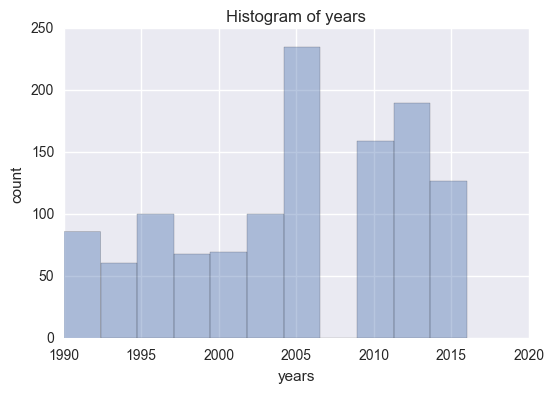

In [6]:
%matplotlib inline
sns.distplot(overall_data['year'], kde = False)
plt.title('Histogram of years')
plt.xlabel('years')
plt.ylabel('count')
plt.show()

### Histogram of Happy Planet Index values

C:\Users\Avi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


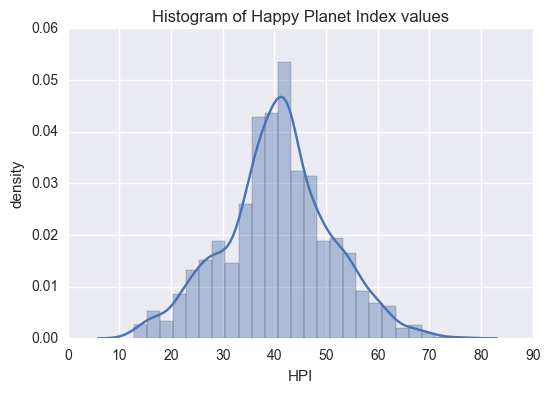

In [7]:
%matplotlib inline
sns.distplot(overall_data['Happy Planet Index'], bins = 25, kde = True)
plt.title('Histogram of Happy Planet Index values')
plt.xlabel('HPI')
plt.ylabel('density')
plt.show()

## Find Most Corrolated features

In [8]:
THRESHOLD = 0.4
data_corr_mat= overall_data.corr(method='spearman')
HPI_correlation = pd.DataFrame(data_corr_mat[data_corr_mat.columns[len(data_corr_mat.columns)-1]])
HPI_correlation = HPI_correlation[abs(HPI_correlation[HPI_correlation.columns\
                                                      [len(HPI_correlation.columns)-1]]) > \
                                      THRESHOLD]
HPI_correlation = HPI_correlation.sort_index(ascending=False)
HPI_relevant_correlation = HPI_correlation[HPI_correlation['Happy Planet Index']<1]
HPI_relevant_correlation = HPI_relevant_correlation.reindex\
(HPI_relevant_correlation['Happy Planet Index'].abs()\
 .sort_values(inplace=False, ascending=False).index)
HPI_relevant_correlation = HPI_relevant_correlation.head(5)
HPI_relevant_correlation = HPI_relevant_correlation.reindex\
(HPI_relevant_correlation['Happy Planet Index'].sort_values(inplace=False, ascending=False).index)
HPI_relevant_correlation.to_csv("Rcorr.csv", sep=',', encoding='utf-8')
print(HPI_relevant_correlation)

                                                    Happy Planet Index
Daily newspapers (per 1000 people)                            0.506649
Firms with a bank loan or line of credit (%)                  0.420970
Working capital financed by banks (%)                         0.419022
Prevalence of HIV total (% of population ages 1...           -0.417042
Firms identifying access to finance as a major ...           -0.560818


## Plot Corrolation matrix- taken 2 positive and 2 negative corrolated features

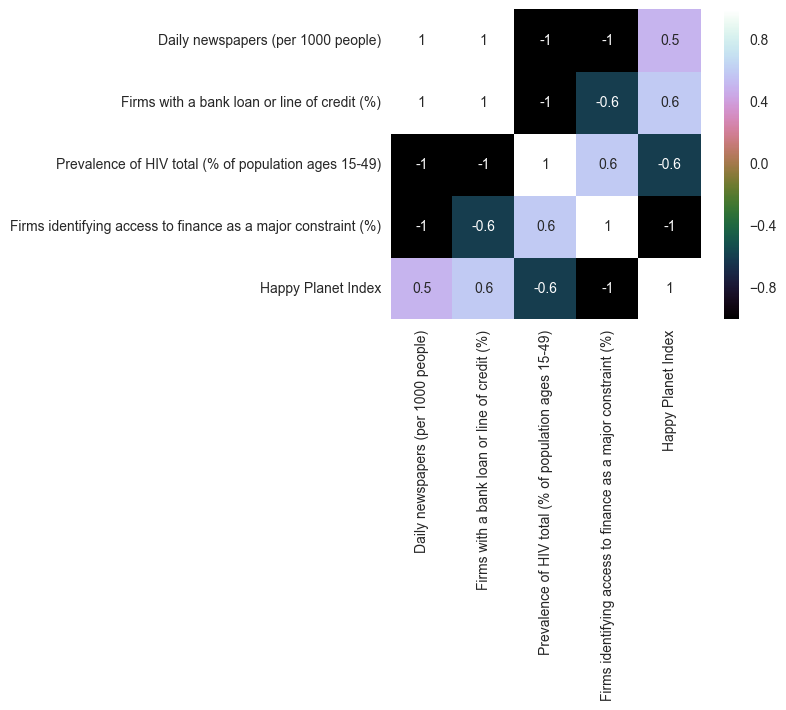

In [9]:
corr_features = ['Daily newspapers (per 1000 people)', 'Firms with a bank loan or line of credit (%)',\
                         'Prevalence of HIV total (% of population ages 15-49)',\
                 'Firms identifying access to finance as a major constraint (%)', 'Happy Planet Index']
overall_data_to_plot = overall_data[corr_features]
data_corr_mat= overall_data_to_plot.corr(method='spearman')
c = data_corr_mat.corr(method='spearman')
sns.heatmap(c, vmax=1, square=True, annot=True, cmap='cubehelix')

# Plotting Data on world map

In [12]:
# initialize list containing images' paths for concatination
countries_corrs = []

## Plotting the Happy Planet Index over the globe

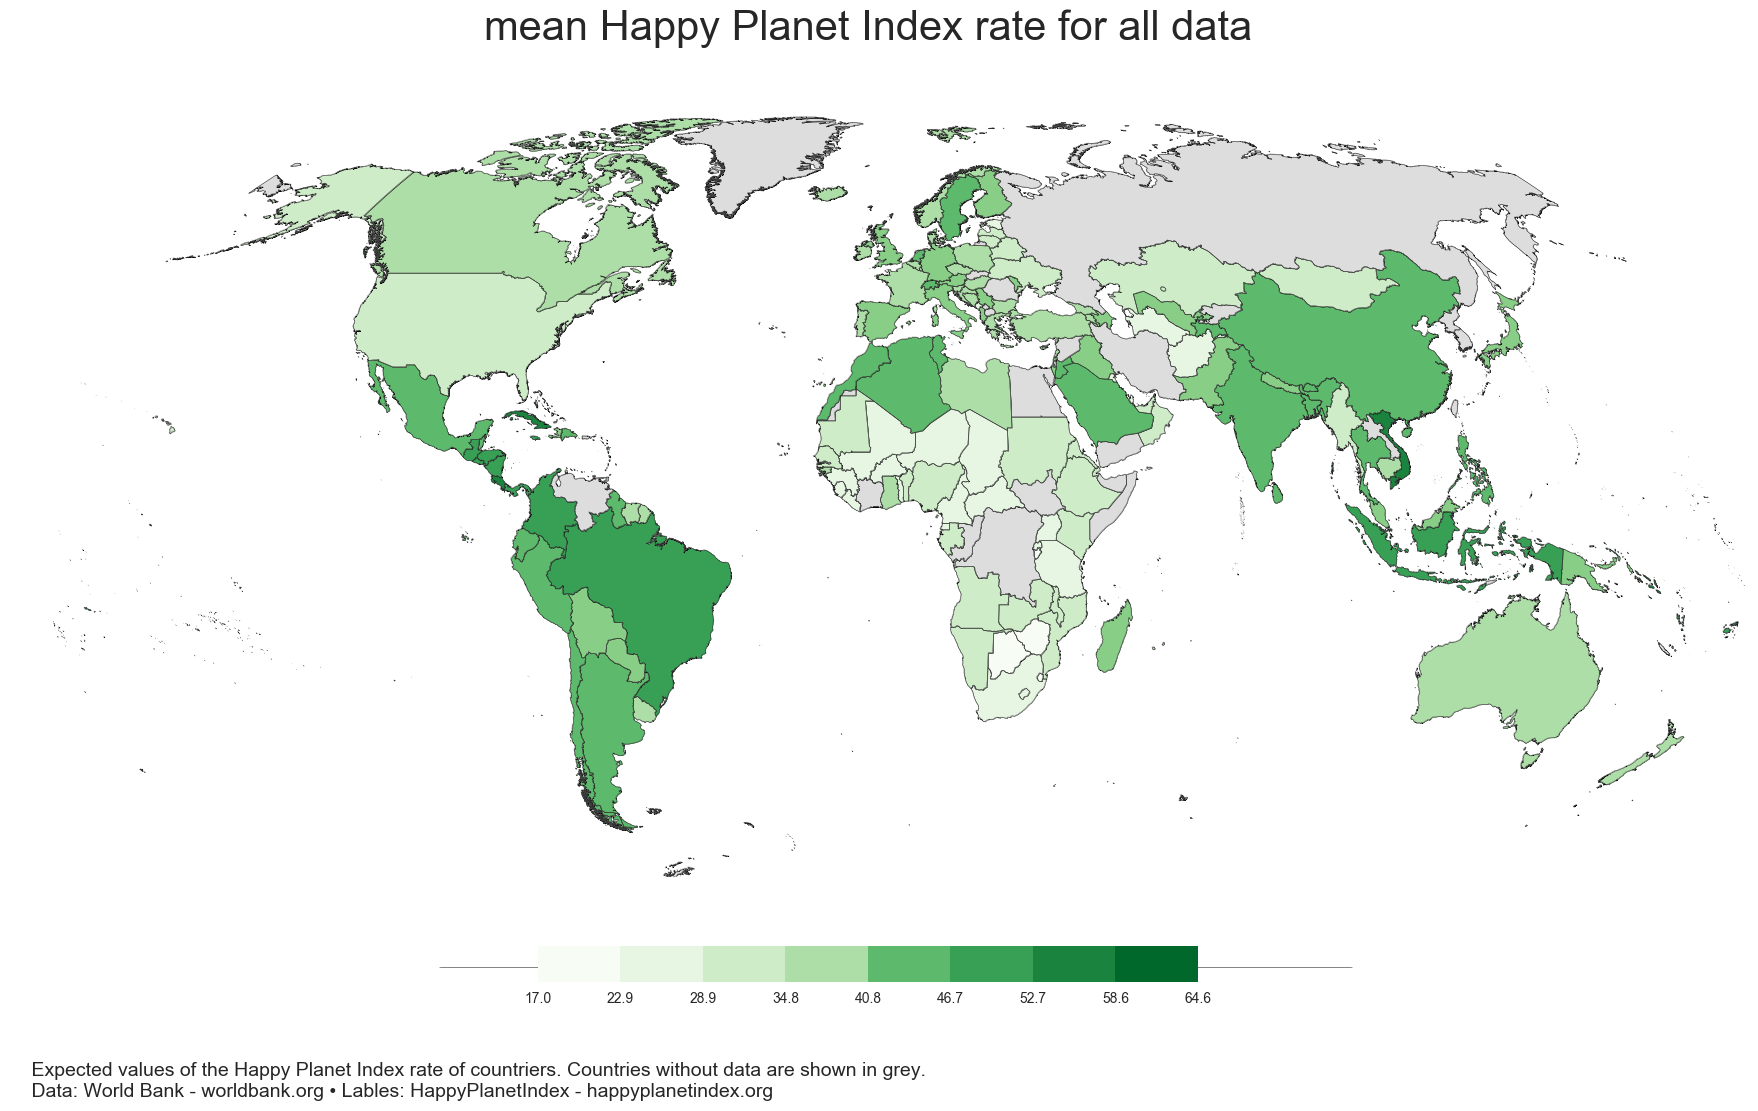

In [18]:
plotDataOnMap(overall_data, feature='Happy Planet Index', year='mean')

## Plotting the Daily newspapers (per 1000 people) over the globe

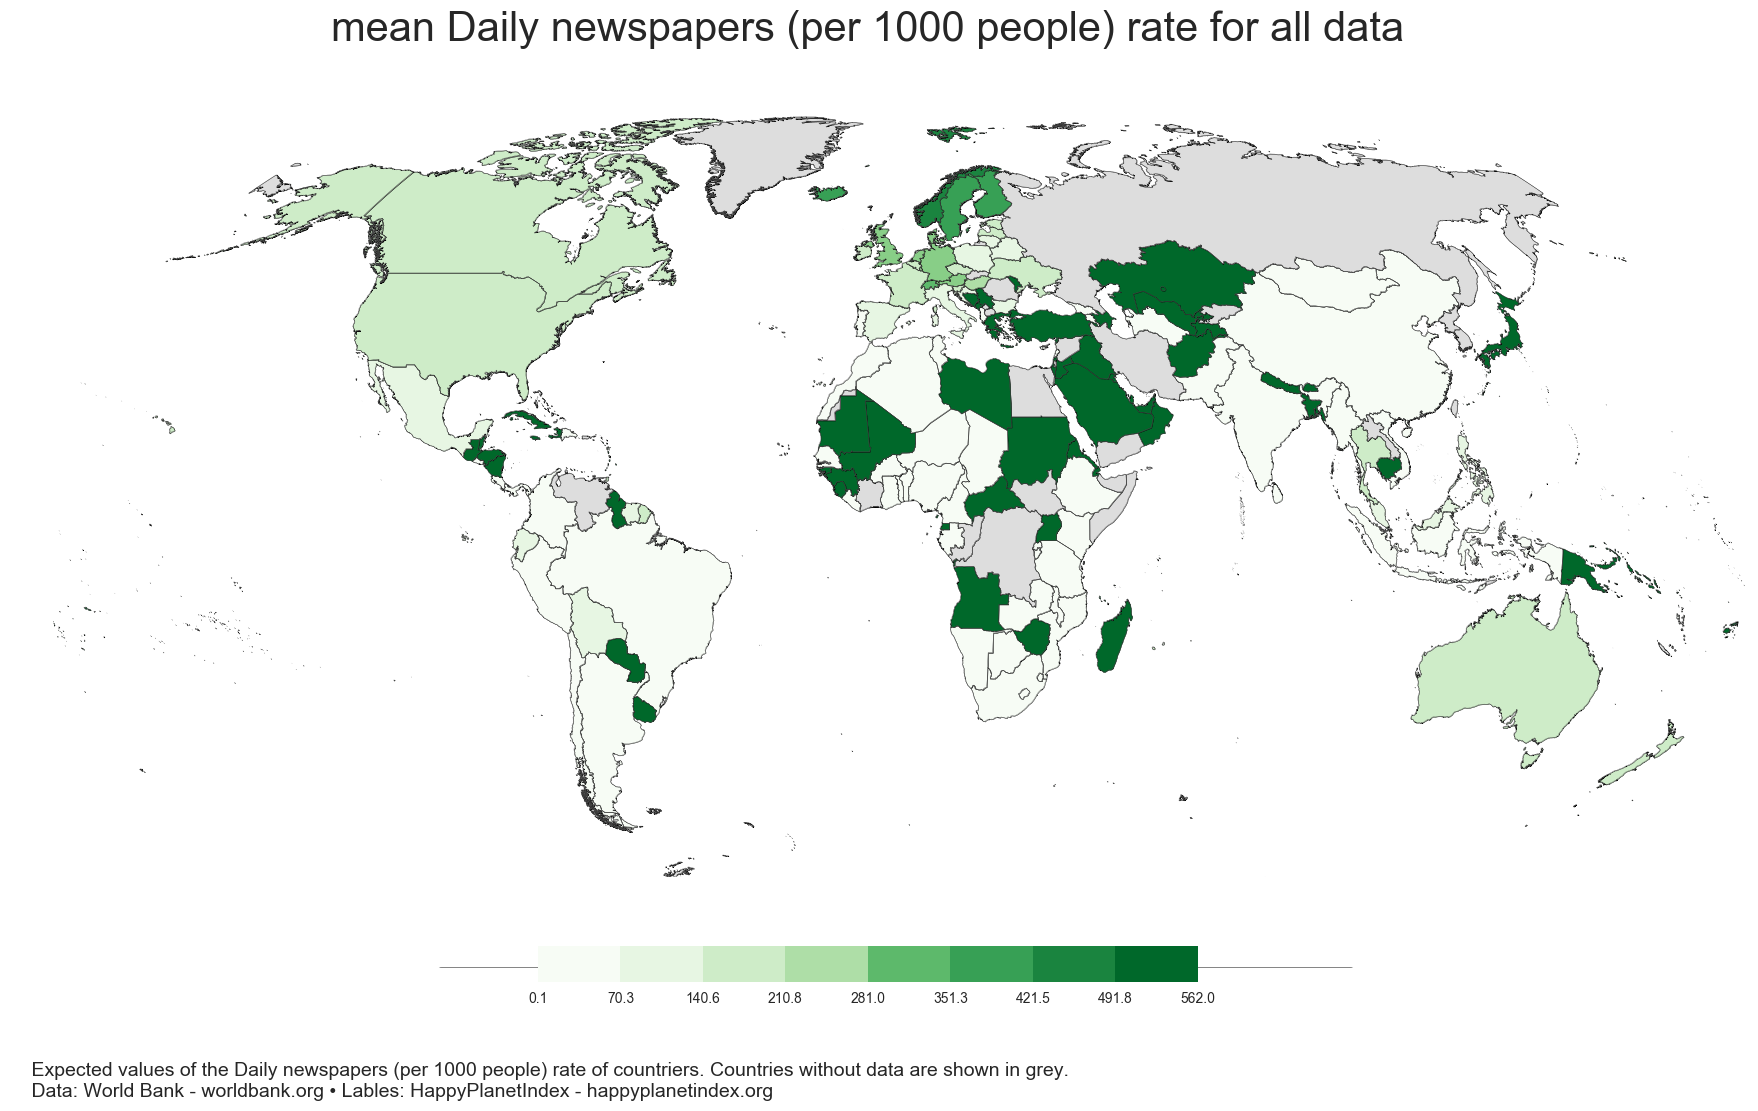

In [19]:
plotDataOnMap(overall_data, feature='Daily newspapers (per 1000 people)', year='mean')

### Which Countries doesn't corrolate in Daily newspapers feature and target

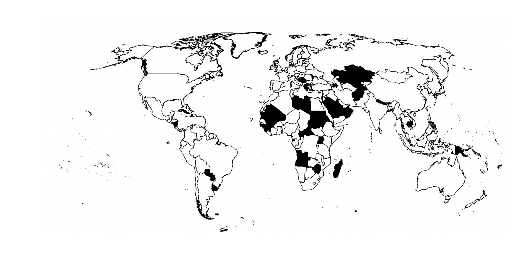

In [20]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + 'Daily newspapers (per 1000 people)_mean.png'
output_image = uncorrolated_plots + 'Daily_newspapers.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the Firms with a bank loan or line of credit over the globe

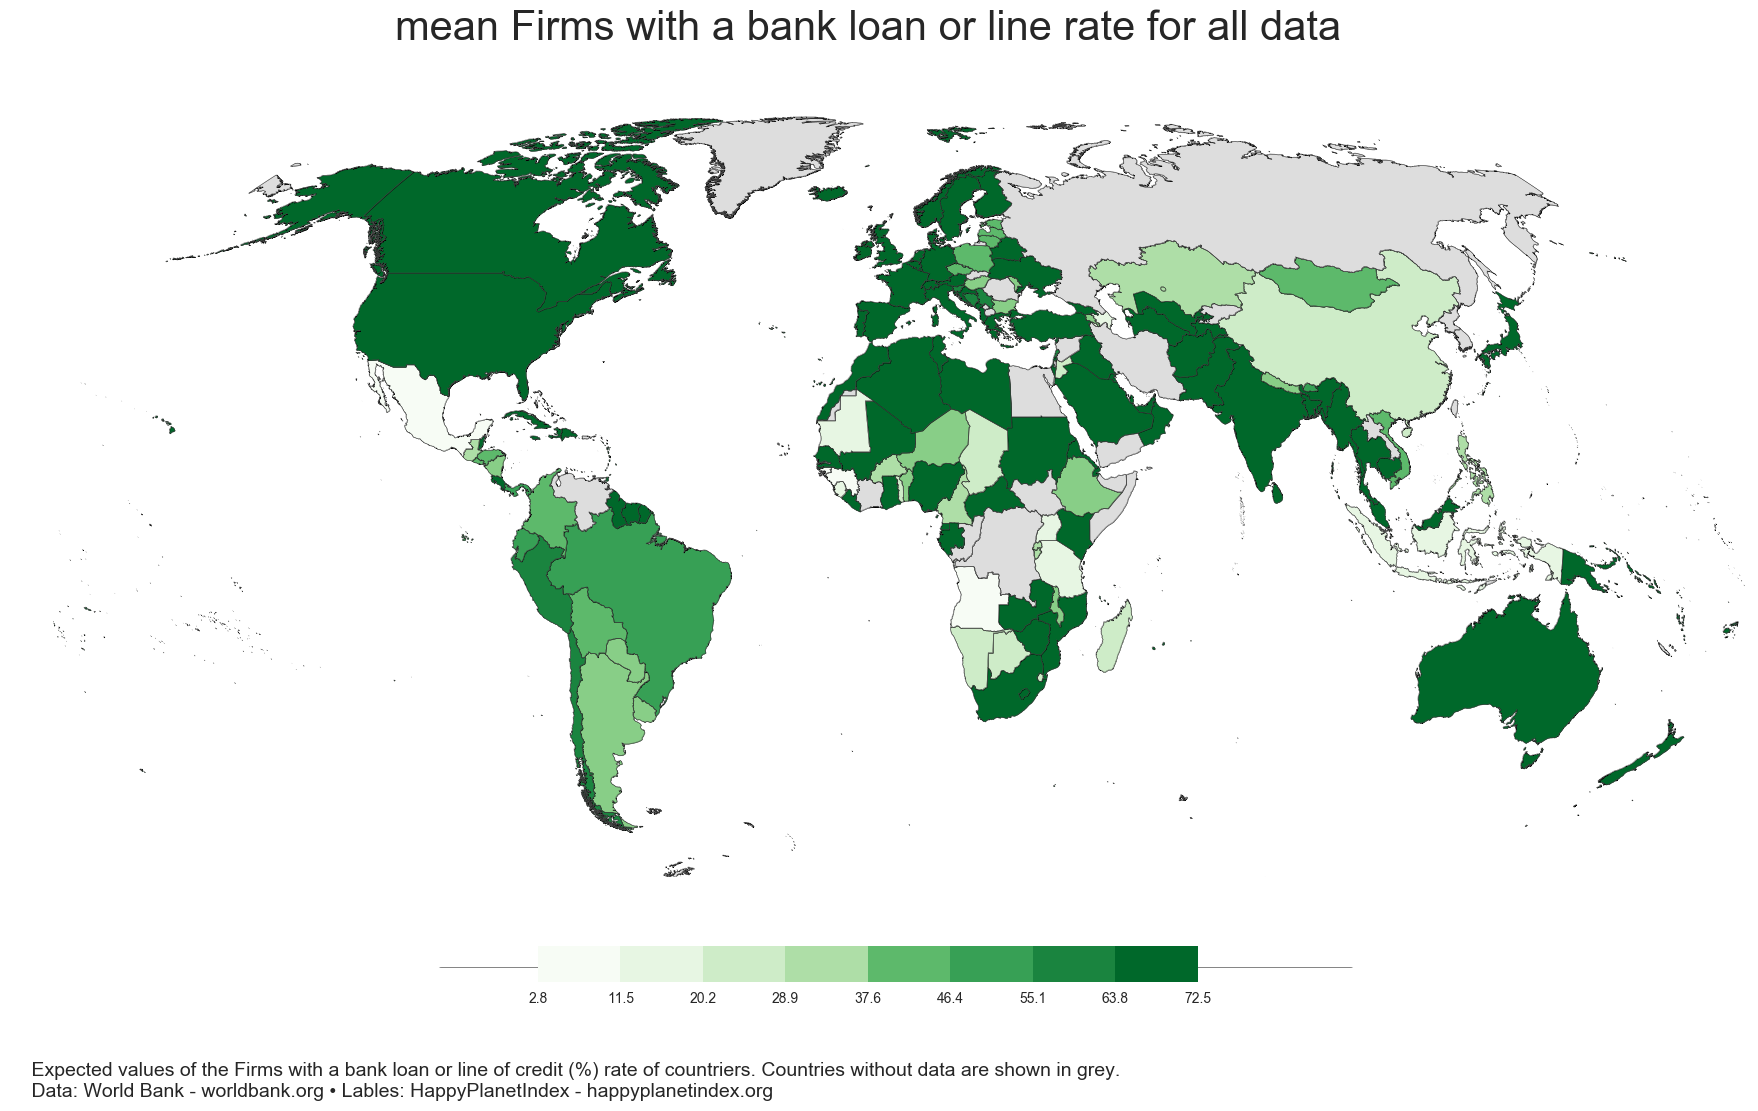

In [21]:
plotDataOnMap(overall_data, feature='Firms with a bank loan or line of credit (%)', year='mean')

### Which Countries doesn't corrolate in Firms with a bank loan feature and target

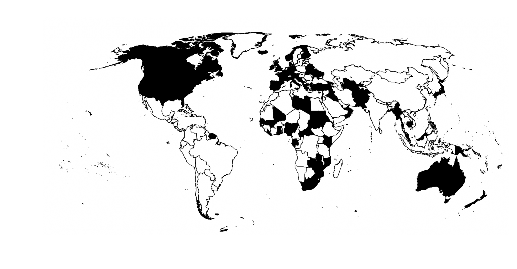

In [32]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + 'Firms with a bank loan or line of credit (%)_mean.png'
output_image = uncorrolated_plots + 'Bank_loan.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the Firms identifying access to finance as a major constraint over the globe

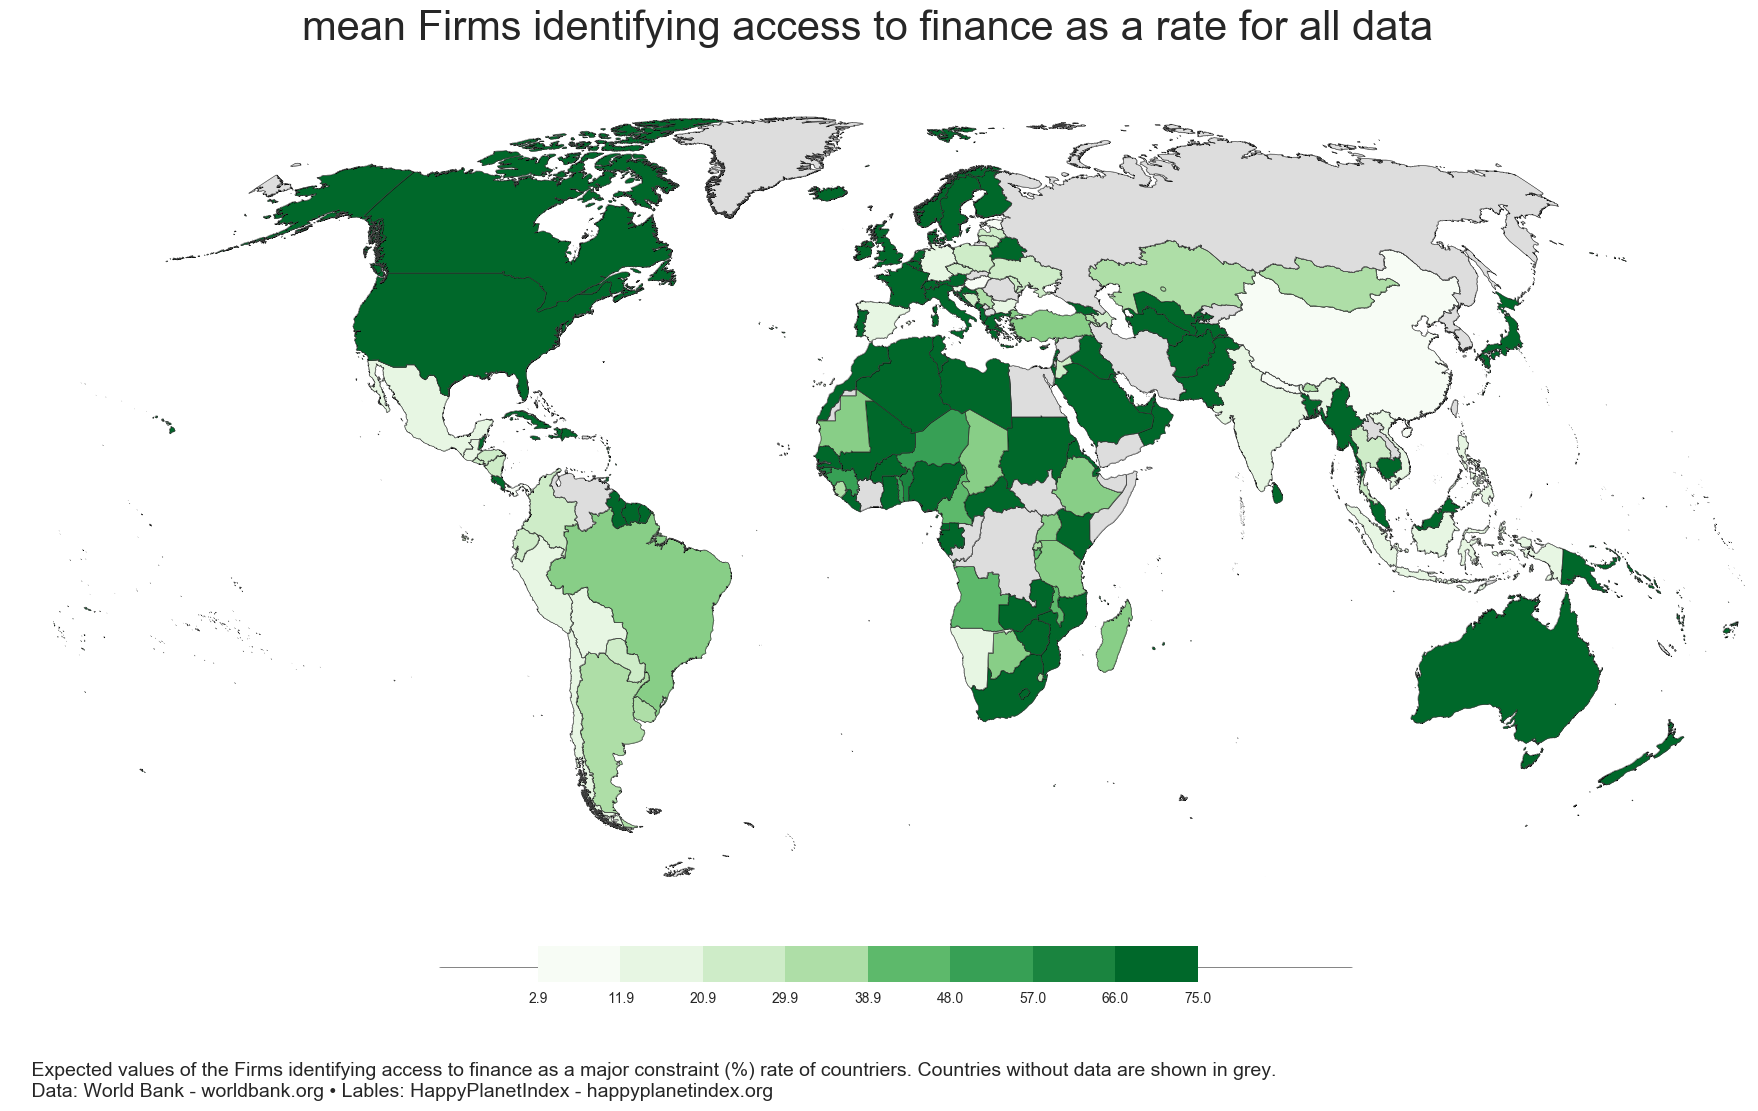

In [26]:
plotDataOnMap(overall_data, feature='Firms identifying access to finance as a major constraint (%)', year='mean')

### Which Countries doesn't corrolate inFirms with a bank loan feature and target

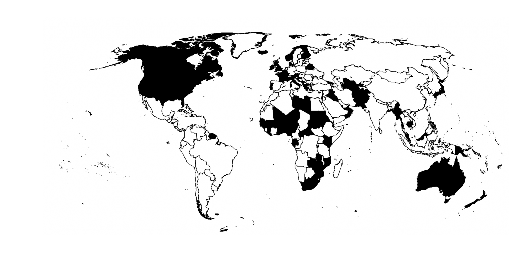

In [33]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + 'Firms identifying access to finance as a major constraint (%)_mean.png'
output_image = uncorrolated_plots + 'Firms_identifying_access.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the Prevalence of HIV total (% of population ages 15-49) over the globe

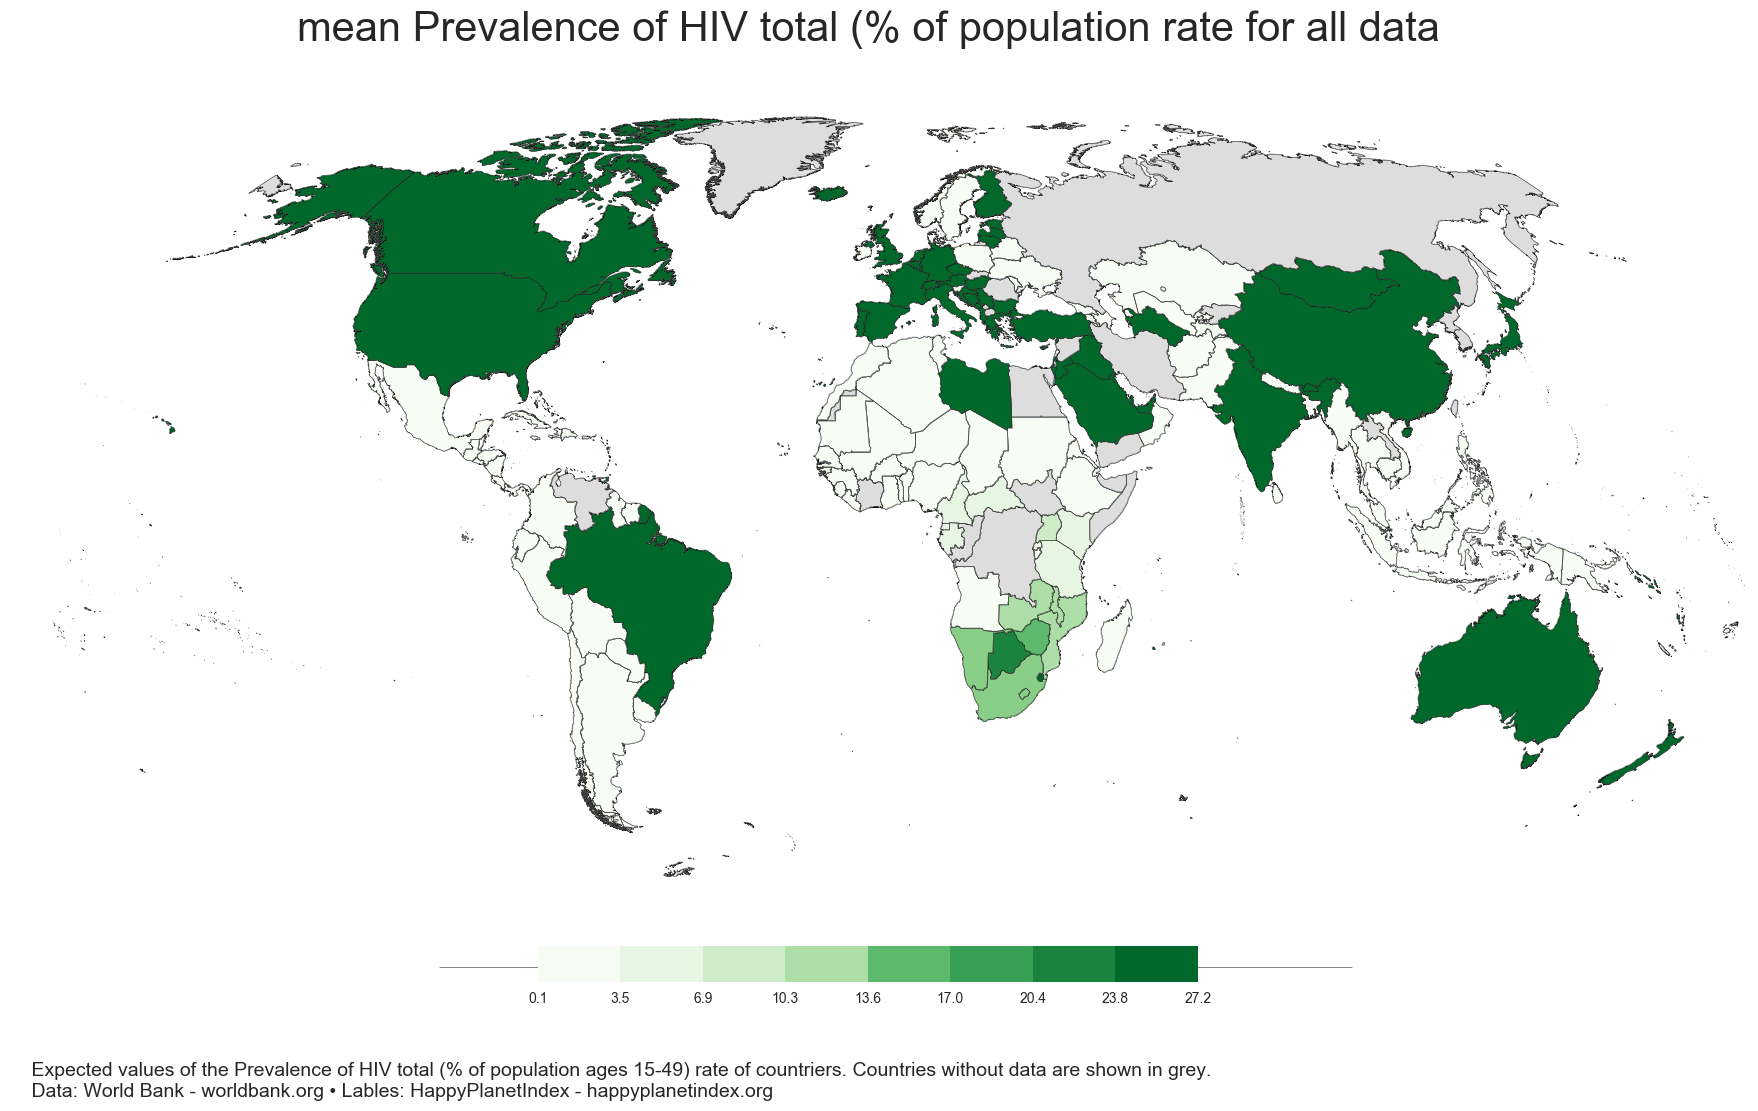

In [28]:
plotDataOnMap(overall_data, feature='Prevalence of HIV total (% of population ages 15-49)', year='mean')

### Which Countries doesn't corrolate in Prevalence of HIV feature and target

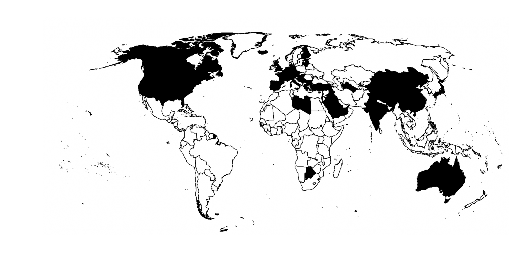

In [34]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + 'Prevalence of HIV total (% of population ages 15-49)_mean.png'
output_image = uncorrolated_plots + 'Prevalence_of_HIV_total.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

### We can see same countries uncorrolated for same features

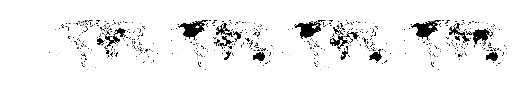

(<matplotlib.image.AxesImage at 0x17b6ad5ba90>, None)

In [38]:
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

def concat_n_images(image_path_list):
    """
    Combines N color images from a list of image paths.
    """
    output = None
    for i, img_path in enumerate(image_path_list):
        img = plt.imread(img_path)[:,:]
        if i==0:
            output = img
        else:
            output = concat_images(output, img)
    return output

out = concat_n_images(countries_corrs)
plt.axis('off')
plt.imshow(out, cmap = 'gray', interpolation = 'bicubic'),plt.show()

## Drop  columns with %(nulls)>90%

In [7]:
THRESH = 0.9
overall_data = overall_data.dropna(1, thresh=(overall_data.shape[0] * (1 - THRESH)))
overall_data.head(5)

country    year  Access to electricity (% of population)  \
0  Afghanistan  2012.0                                     43.0   
1  Afghanistan  2016.0                                     43.0   
2      Albania  2006.0                                      NaN   
3      Albania  2006.0                                      NaN   
4      Albania  2009.0                                      NaN   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                                NaN              
4                                              19.48              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                                NaN    
4                                              48.64    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                 NaN   
4                               19.41   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                        NaN   
4                                       1.90   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                          NaN   
4                                 1.897705e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                             413.03        
1                                             395.78        
2                                            2696.73        
3                                                NaN        
4                                            3065.76        

   Air transport registered carrier departures worldwide         ...          \
0                                           17775.00             ...           
1                                           25389.38             ...           
2                                            4481.00             ...           
3                                                NaN             ...           
4                                            5140.00             ...           

   Stock market capitalization to GDP (%)  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   Stock market return (% year-on-year)  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   Stock market total value traded to GDP (%)  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

   Stock market turnover ratio (%)  Stock price volatility  \
0                              NaN                     NaN   
1                              NaN                     NaN   
2                              NaN                     NaN   
3                              NaN                     NaN   
4                              NaN    

### Impute nulls with medians

In [8]:
overall_data = overall_data.fillna(overall_data.median())
overall_data.head(5)

country    year  Access to electricity (% of population)  \
0  Afghanistan  2012.0                                     43.0   
1  Afghanistan  2016.0                                     43.0   
2      Albania  2006.0                                     99.7   
3      Albania  2006.0                                     99.7   
4      Albania  2009.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                              20.92              
4                                              19.48              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                              51.26    
4                                              48.64    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                4.60   
4                               19.41   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                       2.30   
4                                       1.90   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                 3.860272e+09   
4                                 1.897705e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           2696.730        
3                                           7712.345        
4                                           3065.760        

   Air transport registered carrier departures worldwide         ...          \
0                                           17775.00             ...           
1                                           25389.38             ...           
2                                            4481.00             ...           
3                                           93600.00             ...           
4                                            5140.00             ...           

   Stock market capitalization to GDP (%)  \
0                                  43.185   
1                                  43.185   
2                                  43.185   
3                                  43.185   
4                                  43.185   

   Stock market return (% year-on-year)  \
0                                  4.43   
1                                  4.43   
2                                  4.43   
3                                  4.43   
4                                  4.43   

   Stock market total value traded to GDP (%)  \
0                                       13.19   
1                                       13.19   
2                                       13.19   
3                                       13.19   
4                                       13.19   

   Stock market turnover ratio (%)  Stock price volatility  \
0                            35.97                  18.815   
1                            35.97                  18.815   
2                            35.97                  18.815   
3                            35.97                  18.815   
4                            35.97    

## One Hot Encoding Foreach Country

In [9]:
oh_overall_data = overall_data.drop('country', axis=1)
onehot_overall_col = pd.get_dummies(overall_data['country'], prefix='country')

#check for missing cols in onehot_overall_col
for col in onehot_overall_col.columns:
    if col not in onehot_overall_col.columns:
        onehot_overall_col[col] = 0
        
oh_overall_data = pd.concat([oh_overall_data, onehot_overall_col], axis=1)
overall_data = oh_overall_data
overall_data.head(5)

year  Access to electricity (% of population)  \
0  2012.0                                     43.0   
1  2016.0                                     43.0   
2  2006.0                                     99.7   
3  2006.0                                     99.7   
4  2009.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                              20.92              
4                                              19.48              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                              51.26    
4                                              48.64    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                4.60   
4                               19.41   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                       2.30   
4                                       1.90   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                 3.860272e+09   
4                                 1.897705e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           2696.730        
3                                           7712.345        
4                                           3065.760        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                           25389.38       
2                                            4481.00       
3                                           93600.00       
4                                            5140.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               3.00            
2                                               4.00            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0            

### Change all values' datatypes to float

In [10]:
for variable in overall_data.columns:
    overall_data[variable] = overall_data[variable].astype(np.float)
overall_data.dtypes[:10]

year                                                            float64
Access to electricity (% of population)                         float64
Adolescent fertility rate (births per 1000 women ages 15-19)    float64
Age dependency ratio (% of working-age population)              float64
Agriculture value added (% of GDP)                              float64
Agriculture value added (annual % growth)                       float64
Agriculture value added (constant 2005 US$)                     float64
Agriculture value added per worker (constant 2005 US$)          float64
Air transport registered carrier departures worldwide           float64
CPIA economic management cluster average (1=low to 6=high)      float64
dtype: object

## Split Data into training set and test set

In [11]:
def splitToTrainAndTest(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    train.reset_index(drop=True, inplace=True)
    test = df[~msk]
    test.reset_index(drop=True, inplace=True)
    train.to_csv(path_train)
    test.to_csv(path_test)

splitToTrainAndTest(overall_data)
train_data = pd.read_csv(path_train, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
test_data = pd.read_csv(path_test, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
train_data.head(5)

year  Access to electricity (% of population)  \
0  2012.0                                     43.0   
1  2016.0                                     43.0   
2  2006.0                                     99.7   
3  2012.0                                    100.0   
4  2012.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              20.92              
3                                              20.80              
4                                              20.92              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              51.26    
3                                              45.84    
4                                              51.26    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                                4.60   
3                               21.83   
4                                4.60   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       2.30   
3                                       5.41   
4                                       2.30   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 3.860272e+09   
3                                 2.256162e+09   
4                                 3.860272e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           7712.345        
3                                           3735.370        
4                                           7712.345        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                           25389.38       
2                                           93600.00       
3                                           10309.18       
4                                           93600.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               3.00            
2                                               3.67            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0            

### Partition to factors and class

In [12]:
train_class = train_data['Happy Planet Index']
train_factors = (train_data.drop('Happy Planet Index', axis=1))

test_class = test_data['Happy Planet Index']
test_factors =(test_data.drop('Happy Planet Index', axis=1))
train_factors.head(5)

year  Access to electricity (% of population)  \
0  2012.0                                     43.0   
1  2016.0                                     43.0   
2  2006.0                                     99.7   
3  2012.0                                    100.0   
4  2012.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              20.92              
3                                              20.80              
4                                              20.92              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              51.26    
3                                              45.84    
4                                              51.26    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                                4.60   
3                               21.83   
4                                4.60   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       2.30   
3                                       5.41   
4                                       2.30   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 3.860272e+09   
3                                 2.256162e+09   
4                                 3.860272e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           7712.345        
3                                           3735.370        
4                                           7712.345        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                           25389.38       
2                                           93600.00       
3                                           10309.18       
4                                           93600.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               3.00            
2                                               3.67            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0            

## Binning The Years by Decades

In [13]:
#binning the years train
min_year = min(min(train_factors['year']), min(test_factors['year']))

def decade(year):
    return(math.floor((year-min_year) / 10))

for row in range(train_factors.shape[0]):
    val=train_factors.at[row, 'year']
    new_val=decade(val)
    train_factors.set_value(row, 'year', new_val)
    
#binning the years test

for row in range(test_factors.shape[0]):
    val=test_factors.at[row, 'year']
    new_val=decade(val)
    test_factors.set_value(row, 'year', new_val)
train_factors.head(5)

year  Access to electricity (% of population)  \
0   2.0                                     43.0   
1   2.0                                     43.0   
2   1.0                                     99.7   
3   2.0                                    100.0   
4   2.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              20.92              
3                                              20.80              
4                                              20.92              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              51.26    
3                                              45.84    
4                                              51.26    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                                4.60   
3                               21.83   
4                                4.60   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       2.30   
3                                       5.41   
4                                       2.30   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 3.860272e+09   
3                                 2.256162e+09   
4                                 3.860272e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           7712.345        
3                                           3735.370        
4                                           7712.345        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                           25389.38       
2                                           93600.00       
3                                           10309.18       
4                                           93600.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               3.00            
2                                               3.67            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0             0.0   
1 

## Centering and Scaling and removing features with: $$STD\approx0$$ 

In [14]:
zero_sd = set()

#train
for col in train_factors.columns:
    mean = train_factors[col].mean()
    std = train_factors[col].std()
    if std == 0:
        zero_sd.add(col)
        continue
    for row in range(train_factors.shape[0]):
        train_factors.set_value(row, col, (train_factors.at[row, col] - mean) / std)
class_mean=train_class.mean()
for row in range(train_factors.shape[0]):
    train_class.set_value(row, train_class[row] - class_mean)

#test
for col in test_factors.columns:
    mean = test_factors[col].mean()
    std = test_factors[col].std()
    if std == 0:
        zero_sd.add(col)
        continue
    for row in range(test_factors.shape[0]):
        test_factors.set_value(row, col, (test_factors.at[row, col] - mean) / std)
class_mean = test_class.mean()
for row in range(test_factors.shape[0]):
    test_class.set_value(row, test_class[row] - class_mean)
    
# drop columns with std = 0
new_train_cols = [col for col in train_factors.columns if col not in zero_sd]
new_test_cols = [col for col in test_factors.columns if col not in zero_sd]

train_factors = train_factors[new_train_cols]
test_factors = test_factors[new_test_cols]

train_factors.head(5)

year  Access to electricity (% of population)  \
0  1.374375                                -3.167555   
1  1.374375                                -3.167555   
2  0.002998                                 0.274600   
3  1.374375                                 0.292813   
4  1.374375                                 0.274600   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                           1.540082              
1                                           1.222828              
2                                          -0.378068              
3                                          -0.381510              
4                                          -0.378068              

   Age dependency ratio (% of working-age population)  \
0                                           3.071887    
1                                           2.649464    
2                                          -0.286911    
3                                          -0.700184    
4                                          -0.286911    

   Agriculture value added (% of GDP)  \
0                            1.691671   
1                            1.626754   
2                           -0.369193   
3                            1.406242   
4                           -0.369193   

   Agriculture value added (annual % growth)  \
0                                   2.329308   
1                                   0.003582   
2                                   0.060585   
3                                   0.503784   
4                                   0.060585   

   Agriculture value added (constant 2005 US$)  \
0                                    -0.300074   
1                                    -0.298420   
2                                    -0.254690   
3                                    -0.314618   
4                                    -0.254690   

   Agriculture value added per worker (constant 2005 US$)  \
0                                          -0.801784        
1                                          -0.802819        
2                                          -0.364182        
3                                          -0.602606        
4                                          -0.364182        

   Air transport registered carrier departures worldwide  \
0                                          -0.281022       
1                                          -0.269645       
2                                          -0.167725       
3                                          -0.292178       
4                                          -0.167725       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                          -2.388899            
1                                          -2.388899            
2                                           0.038929            
3                                           0.038929            
4                                           0.038929            

         ...         country_Togo  country_Turkey  country_Turkmenistan  \
0        ...            -0.046778         -0.0812             -0.033059   
1        ...            -0.046778         -0.0812             -0.033059   
2        ...            -0.046778         -0.0812             -0.033059   
3        ...            -0.046778         -0.0812             -0.033059   
4        ...            -0.046778         -0.0812             -0.033059   

   country_Uganda  country_United Arab Emirates  country_United Kingdom  \
0       -0.033059                     -0.057323               -0.160489   
1       -0.033059                     -0.057323               -0.160489   
2       -0.033059                     -0.057323               -0.160489   
3       -0.033059                     -0.057323               -0.160489   
4       -0.033059                     -0.057323               -0.160489   

   country_Uruguay  country_Vietnam  country_Zambia  country_Zimba

## Feature selection using Enet model

In [15]:
# run elastic model for feature selection 
enet = ElasticNetCV(max_iter=10000)
enet.fit(train_factors, train_class)
chosen_features_list = [(train_factors.columns[i],enet.coef_[i]) for i in range(enet.coef_.shape[0])]

def comp(tuple):
    return abs(tuple[1])

chosen_features_list.sort(key=comp, reverse=True)
headers = [['correlated feature', 'linear correlation rate to target']]
data = headers + [[x[0], x[1]]\
                  for x in chosen_features_list if x[1] != 0.0 ]
headers = data.pop(0) # gives the headers as list and leaves data
table = pd.DataFrame(data, columns=headers)
print("Enet Strong factors are: ")
table.head(10)

Enet Strong factors are: 


correlated feature  \
0  Third-party notification if 9 workers are dism...   
1  Third-party notification if 1 worker is dismis...   
2              Life expectancy at birth male (years)   
3                                 country_Luxembourg   
4                      Remittance inflows to GDP (%)   
5                                     country_Sweden   
6            Life expectancy at birth female (years)   
7                                    country_Burundi   
8                   Priority rules for redundancies?   
9  Prevalence of HIV total (% of population ages ...   

   linear correlation rate to target  
0                           1.409895  
1                          -1.208154  
2                           1.104392  
3                          -0.976598  
4                           0.974620  
5                           0.859198  
6                           0.834582  
7                          -0.777748  
8                          -0.775139  
9                          -0.736118

## Countries corrolated to target plot

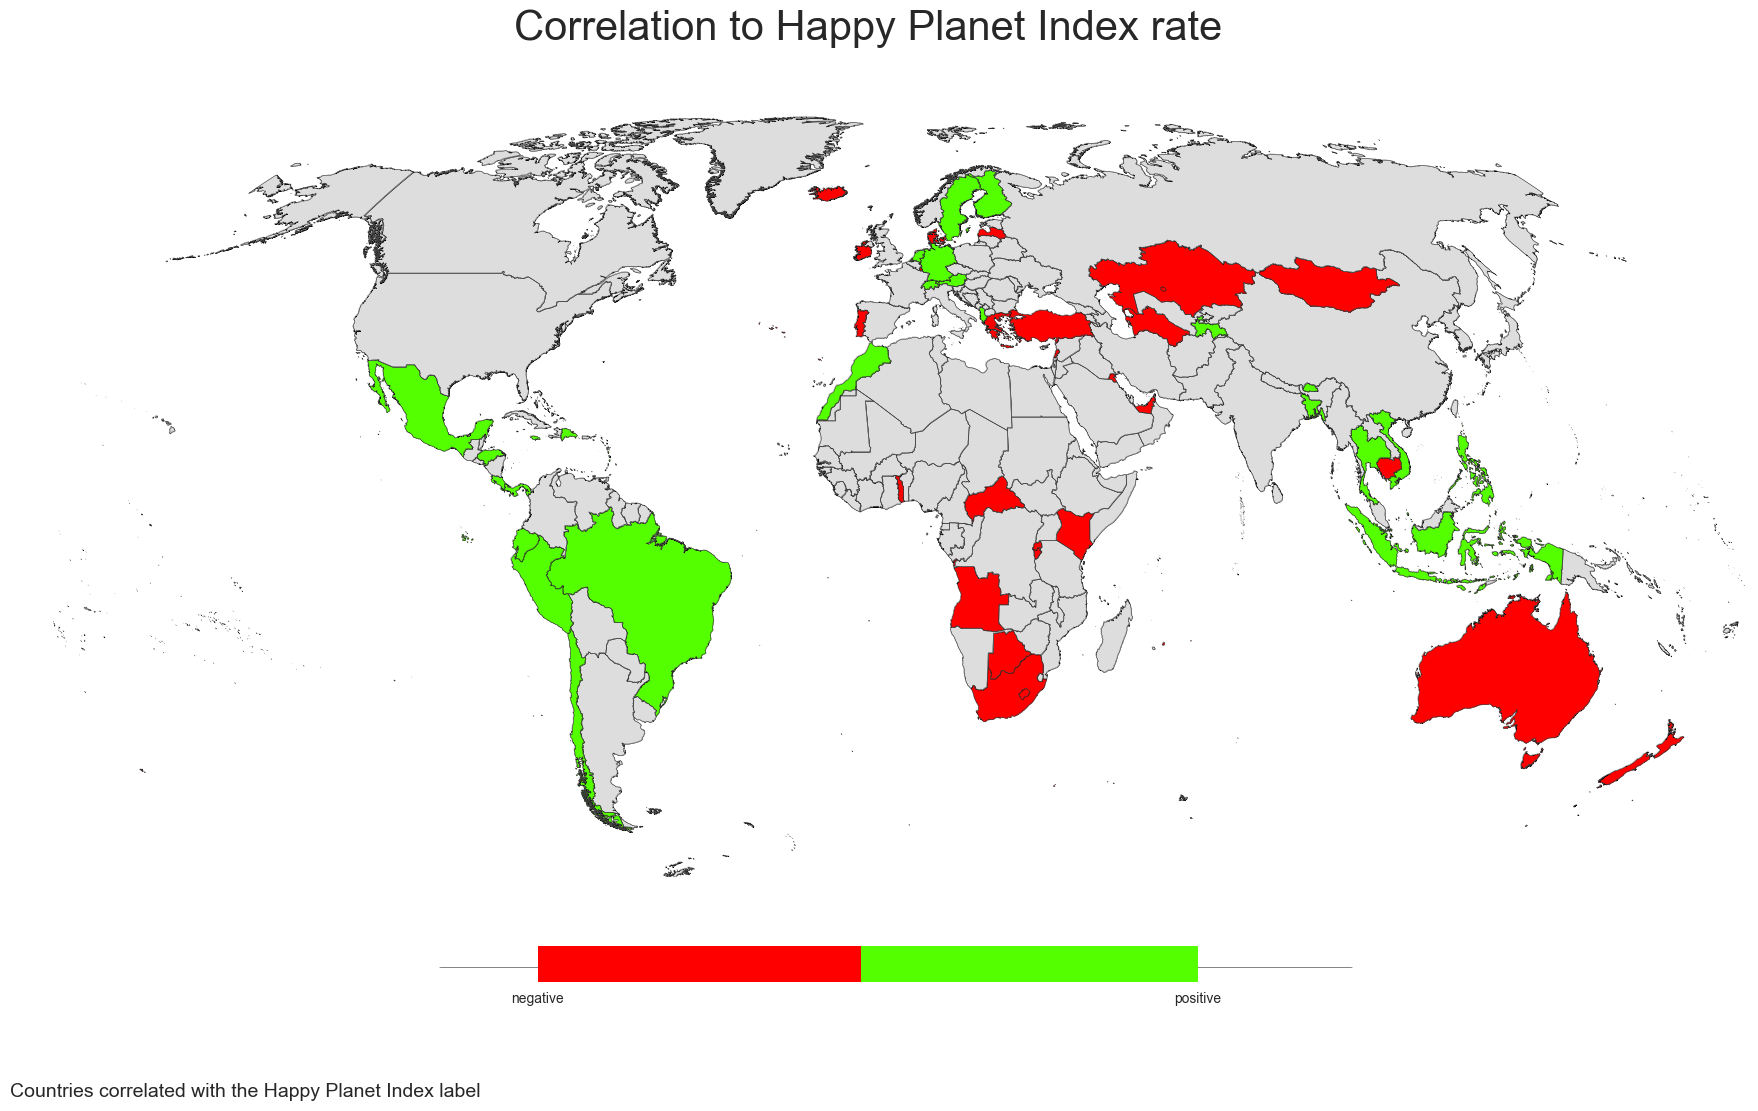

In [16]:
headers = [['country', 'Correlation to Happy Planet Index']]
data = headers + [[x[0].split('country_')[1], np.sign(x[1])]\
                  for x in chosen_features_list if x[0].startswith('country_') and x[1] != 0.0 ]
headers = data.pop(0) # gives the headers as list and leaves data
df = pd.DataFrame(data, columns=headers)
plotDataOnMap(df, year='mean', feature="Correlation to Happy Planet Index", binary=True,\
              descripton='Countries correlated with the Happy Planet Index label')

## Take the rellevan features

In [32]:
chosen_features = [x[0] for x in chosen_features_list if x[1] != 0.0 ]
train_factors = train_factors[chosen_features]
test_factors = test_factors[chosen_features]
train_factors.head(5)

Third-party notification if 9 workers are dismissed?  \
0                                           0.213692      
1                                           0.213692      
2                                           0.213692      
3                                           0.213692      
4                                           0.213692      

   Third-party notification if 1 worker is dismissed?  \
0                                          -0.229949    
1                                           4.344037    
2                                          -0.229949    
3                                          -0.229949    
4                                          -0.229949    

   Life expectancy at birth male (years)  country_Luxembourg  \
0                              -1.665694           -0.160489   
1                              -1.605364           -0.160489   
2                               0.276330           -0.160489   
3                               0.506156           -0.160489   
4                               0.276330           -0.160489   

   Remittance inflows to GDP (%)  country_Sweden  \
0                      -0.162228       -0.160489   
1                      -0.288965       -0.160489   
2                       3.223112       -0.160489   
3                      -0.288965       -0.160489   
4                       1.570657       -0.160489   

   Life expectancy at birth female (years)  country_Burundi  \
0                                -1.828827        -0.074084   
1                                -1.774933        -0.074084   
2                                 0.325672        -0.074084   
3                                 0.508661        -0.074084   
4                                 0.325672        -0.074084   

   Priority rules for redundancies?  \
0                         -0.232569   
1                         -0.232569   
2                         -0.232569   
3                         -0.232569   
4                         -0.232569   

   Prevalence of HIV total (% of population ages 15-49)  \
0                                          -0.318581      
1                                          -0.318581      
2                                          -0.212670      
3                                          -0.212670      
4                                          -0.212670      

                                   ...                                   \
0                                  ...                                    
1                                  ...                                    
2                                  ...                                    
3                                  ...                                    
4                                  ...                                    

   country_Ireland  country_Kenya  Pension fund assets to GDP (%)  \
0        -0.170922      -0.066227                       -0.250911   
1        -0.170922      -0.066227                       -0.250911   
2        -0.170922      -0.066227                       -0.250911   
3        -0.170922      -0.066227                       -0.250911   
4        -0.170922      -0.066227                       -0.828357   

   country_Chile  country_Iceland  \
0      -0.087754        -0.160489   
1      -0.087754        -0.160489   
2      -0.087754        -0.160489   
3      -0.087754        -0.160489   
4      -0.087754        -0.160489   

   Population density (people per sq. km of land area)  \
0                                          -0.238967     
1                                          -0.231127     
2                                          -0.142890     
3                                          -0.076422     
4                                          -0.142890     

   CPIA property rights and rule-based governance rating (1=low to 6=high)  \
0                                          -6.075733                         
1                                          -

## Apply PCA

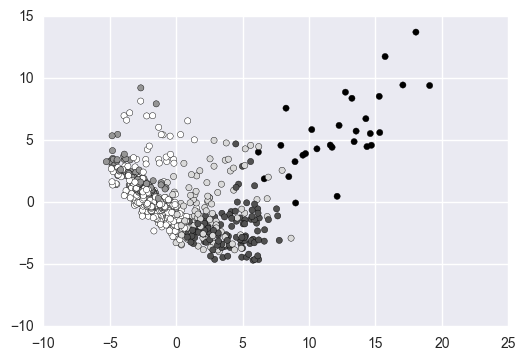

In [33]:
# Import the kmeans clustering model.
from sklearn.cluster import KMeans

# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=5, random_state=1)
# Get only the numeric columns from games.
# Fit the model using the good columns.
kmeans_model.fit(train_factors)
# Get the cluster assignments.
labels = kmeans_model.labels_
#Import the PCA model.
from sklearn.decomposition import PCA

# Create a PCA model.
pca_2 = PCA(2)
# Fit the PCA model on the numeric columns from earlier.
plot_columns = pca_2.fit_transform(train_factors)
# Make a scatter plot of each game, shaded according to cluster assignment.
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
# Show the plot.
plt.show()

# Random forest

In [50]:
# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model with some parameters.
model = RandomForestRegressor(n_estimators=100,min_samples_leaf=33, random_state=1)
# Fit the model to the data.
model.fit(train_factors, train_class)
# Make predictions.
test_predictions = model.predict(test_factors)
tarin_predictions = model.predict(train_factors)


# Compute the error.test_mse = mean_squared_error(y_test, rf.predict(test_factors))
train_mse = mean_squared_error(train_class, tarin_predictions)
test_mse = mean_squared_error(test_class, test_predictions)

print("train MSE, %.4f, test MSE: %.4f" % (train_mse, test_mse))

train MSE, 44.6707, test MSE: 58.2746
